In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    # for filename in filenames:
        # print(os.path.join(dirname, filename))
    print(dirname)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input
/kaggle/input/YouTube-real
/kaggle/input/Celeb-synthesis
/kaggle/input/Celeb-real


In [2]:
celeb_real = "/kaggle/input/Celeb-real"
celeb_synthesis = "/kaggle/input/Celeb-synthesis"
youtube_real = "/kaggle/input/YouTube-real"

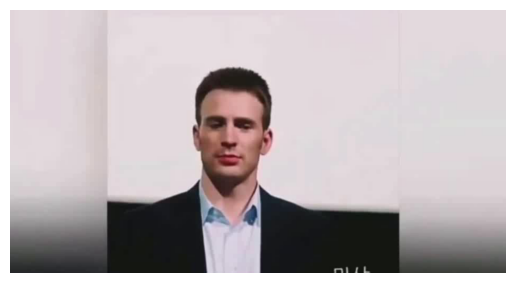

In [3]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def show_frame_from_video(video_path, frame_number=0):
    """
    Extracts a specific frame from a video.

    Parameters:
    - video_path (str): Path to the video file.
    - frame_number (int): The frame number to extract (default is 0, the first frame).

    Returns:
    - frame: The extracted frame as a NumPy array.
    """
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        raise ValueError("Could not open the video file.")
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    
    if not ret:
        raise ValueError("Could not read the frame.")
    
    cap.release()
    
    # Convert from BGR (OpenCV) to RGB (Matplotlib)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Display the image inline
    plt.imshow(frame_rgb)
    plt.axis('off')  # Hide axes
    plt.show()

    return frame

video_path = "/kaggle/input/Celeb-real/id4_0004.mp4"
frame = show_frame_from_video(video_path, frame_number=0)



In [4]:
print("Frame Shape:", frame.shape)  # Height, Width, Channels
print("Frame Size:", frame.size)    # Total number of pixels
print("Frame Data Type:", frame.dtype)

Frame Shape: (500, 942, 3)
Frame Size: 1413000
Frame Data Type: uint8


In [8]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

def extract_frames(video_path, output_dir, max_frames=30):
    os.makedirs(output_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    while cap.isOpened() and frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        cv2.imwrite(os.path.join(output_dir, f"frame_{frame_count:04d}.jpg"), frame)
        frame_count += 1
    cap.release()

def balanced_split(real_videos, fake_videos, split_ratio=(0.7, 0.15, 0.15)):
    # Ensure we use the minimum class count
    min_count = min(len(real_videos), len(fake_videos))
    real_videos = real_videos[:min_count]
    fake_videos = fake_videos[:min_count]
    
    # Create indices and shuffle
    indices = np.arange(min_count)
    np.random.shuffle(indices)
    
    # Calculate split points
    train_end = int(min_count * split_ratio[0])
    val_end = train_end + int(min_count * split_ratio[1])
    
    # Split indices
    splits = {
        'train': indices[:train_end],
        'val': indices[train_end:val_end],
        'test': indices[val_end:]
    }
    
    # Create balanced splits
    split_data = {}
    for split_name, idx in splits.items():
        split_data[split_name] = {
            'real': [real_videos[i] for i in idx],
            'fake': [fake_videos[i] for i in idx]
        }
    
    return split_data

def process_balanced_splits(split_data, output_base):
    for split_name in ['train', 'val', 'test']:
        # Process real videos
        real_output = os.path.join(output_base, split_name, 'real')
        for video in tqdm(split_data[split_name]['real'], desc=f'Processing {split_name} real'):
            vid_name = os.path.splitext(os.path.basename(video))[0]
            extract_frames(video, os.path.join(real_output, vid_name))
        
        # Process fake videos
        fake_output = os.path.join(output_base, split_name, 'fake')
        for video in tqdm(split_data[split_name]['fake'], desc=f'Processing {split_name} fake'):
            vid_name = os.path.splitext(os.path.basename(video))[0]
            extract_frames(video, os.path.join(fake_output, vid_name))

# Collect video paths
real_dirs = [celeb_real, youtube_real]
fake_dirs = [celeb_synthesis]

real_videos = [os.path.join(d, v) for d in real_dirs for v in os.listdir(d)]
fake_videos = [os.path.join(d, v) for d in fake_dirs for v in os.listdir(d)]

# Shuffle and split
split_data = balanced_split(real_videos, fake_videos)
process_balanced_splits(split_data, '/kaggle/working/data')

class BalancedDeepfakeDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.split_dir = os.path.join(root_dir, split)
        self.samples = []
        
        # Load real and fake with balanced classes
        real_path = os.path.join(self.split_dir, 'real')
        fake_path = os.path.join(self.split_dir, 'fake')
        
        # Collect real samples
        for vid_dir in os.listdir(real_path):
            frames = os.listdir(os.path.join(real_path, vid_dir))
            self.samples.extend([(os.path.join(real_path, vid_dir, f), 0) for f in frames])
        
        # Collect fake samples
        for vid_dir in os.listdir(fake_path):
            frames = os.listdir(os.path.join(fake_path, vid_dir))
            self.samples.extend([(os.path.join(fake_path, vid_dir, f), 1) for f in frames])
        
        # Shuffle to mix real and fake
        np.random.shuffle(self.samples)
        self.transform = transform

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(img)
        return img, label

# Transforms remain the same
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = BalancedDeepfakeDataset('/kaggle/working/data', 'train', train_transform)
val_dataset = BalancedDeepfakeDataset('/kaggle/working/data', 'val', val_transform)
test_dataset = BalancedDeepfakeDataset('/kaggle/working/data', 'test', val_transform)

# Create balanced data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

Processing test fake: 100%|██████████| 62/62 [00:04<00:00, 15.15it/s]


## Model

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.nn.functional as F

# Ensure EfficientNet-B4 is imported properly
from torchvision.models.efficientnet import efficientnet_b4, EfficientNet_B4_Weights

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
import cv2

# DCT Transform Function
def dct_transform(img):
    """Apply Discrete Cosine Transform (DCT) to an image."""
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    img_gray = np.float32(img_gray) / 255.0  # Normalize
    dct_coeffs = cv2.dct(img_gray)  # Apply DCT
    dct_resized = cv2.resize(dct_coeffs, (24, 24))  # Resize to match CNN input
    return dct_resized
    
# Define the Dual-Stream Attention Model
class DualStreamAttention(nn.Module):
    def __init__(self, num_classes=2):
        super(DualStreamAttention, self).__init__()

        # EfficientNet-B4 Backbone for Spatial Features
        self.efficientnet = efficientnet_b4(weights=EfficientNet_B4_Weights.DEFAULT)
        self.spatial_extractor = nn.Sequential(*list(self.efficientnet.children())[:-2])  # Remove classifier head
        self.spatial_pool = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling
        self.spatial_fc = nn.Linear(1792, 1536)  # Reduce to expected size

        # CNN for Frequency Features
        self.freq_extractor = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(64 * 6 * 6, 2304) 
        )

        # Attention Mechanism
        self.attn_fc = nn.Linear(3840, 512)  
        self.attn = nn.Sequential(
            nn.Tanh(),
            nn.Linear(512, 3840),  # Should match the input size!
            nn.Sigmoid()
        )


        # Final Classifier
        self.classifier = nn.Sequential(
            nn.Linear(3840, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, spatial_input, freq_input):
        # Spatial Feature Extraction
        spatial_features = self.spatial_extractor(spatial_input)
        spatial_features = self.spatial_pool(spatial_features)
        spatial_features = spatial_features.view(spatial_features.size(0), -1)
        spatial_features = self.spatial_fc(spatial_features)  # Ensure (B, 1536)

        # Frequency Feature Extraction
        freq_features = self.freq_extractor(freq_input)  # Ensure (B, 2304)

        # Debugging: Print Feature Shapes
        # print(f"Spatial Features Shape: {spatial_features.shape}")  # (B, 1536)
        # print(f"Freq Features Shape: {freq_features.shape}")  # (B, 2304)

        # Feature Fusion
        combined_features = torch.cat((spatial_features, freq_features), dim=1)  # (B, 3840)

        # Attention Mechanism
        attn_weights = self.attn(self.attn_fc(combined_features))
        weighted_features = attn_weights * combined_features  # Element-wise multiplication

        # Classification
        output = self.classifier(weighted_features)
        return output


In [10]:
def evaluate_model(model, val_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for spatial_imgs, labels in val_loader:
            spatial_imgs = spatial_imgs.to(device)
            labels = labels.to(device)

            # Convert images to frequency domain
            batch_size = spatial_imgs.shape[0]
            freq_imgs = np.zeros((batch_size, 24, 24), dtype=np.float32)

            for i in range(batch_size):
                img_np = spatial_imgs[i].permute(1, 2, 0).cpu().numpy()
                freq_imgs[i] = dct_transform(img_np)

            freq_imgs = torch.from_numpy(freq_imgs).unsqueeze(1).to(device)

            # Forward pass
            outputs = model(spatial_imgs, freq_imgs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total


In [11]:
from torchvision import models
import torch.optim as optim


def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for spatial_imgs, labels in train_loader:
            spatial_imgs = spatial_imgs.to(device)
            labels = labels.to(device)

            # Convert spatial images to frequency domain
            batch_size = spatial_imgs.shape[0]
            freq_imgs = np.zeros((batch_size, 24, 24), dtype=np.float32)

            for i in range(batch_size):
                img_np = spatial_imgs[i].permute(1, 2, 0).cpu().numpy()
                freq_imgs[i] = dct_transform(img_np)

            freq_imgs = torch.from_numpy(freq_imgs).unsqueeze(1).to(device)  # (B, 1, 24, 24)

            # Forward pass
            outputs = model(spatial_imgs, freq_imgs)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Stats
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        val_acc = evaluate_model(model, val_loader, device)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")



In [12]:
# Initialize Model
model = DualStreamAttention(num_classes=2)

# Train
train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-4)


Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 215MB/s]


Epoch 1/10, Loss: 257.4997, Train Acc: 92.12%, Val Acc: 94.58%
Epoch 2/10, Loss: 71.5994, Train Acc: 98.16%, Val Acc: 96.38%
Epoch 3/10, Loss: 38.1541, Train Acc: 99.01%, Val Acc: 96.55%
Epoch 4/10, Loss: 24.8760, Train Acc: 99.37%, Val Acc: 96.96%
Epoch 5/10, Loss: 18.7039, Train Acc: 99.58%, Val Acc: 97.42%
Epoch 6/10, Loss: 15.5482, Train Acc: 99.66%, Val Acc: 97.33%
Epoch 7/10, Loss: 12.9708, Train Acc: 99.72%, Val Acc: 97.25%
Epoch 8/10, Loss: 13.4499, Train Acc: 99.73%, Val Acc: 97.42%
Epoch 9/10, Loss: 11.7266, Train Acc: 99.79%, Val Acc: 97.93%
Epoch 10/10, Loss: 7.8193, Train Acc: 99.83%, Val Acc: 97.70%


In [14]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

def evaluate_model(model, dataloader, device):
    model.eval()
    y_true, y_pred, y_probs = [], [], []
    
    with torch.no_grad():
        for spatial_imgs, labels in dataloader:
            spatial_imgs = spatial_imgs.to(device)
            labels = labels.to(device)

            # Convert spatial images to frequency domain
            batch_size = spatial_imgs.shape[0]
            freq_imgs = np.zeros((batch_size, 24, 24), dtype=np.float32)
            
            for i in range(batch_size):
                img_np = spatial_imgs[i].permute(1, 2, 0).cpu().numpy()
                freq_imgs[i] = dct_transform(img_np)
            
            freq_imgs = torch.from_numpy(freq_imgs).unsqueeze(1).to(device)

            # Model prediction
            outputs = model(spatial_imgs, freq_imgs)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            _, predicted = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)
    
    # Compute metrics
    print("Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))
    
    cm = confusion_matrix(y_true, y_pred)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    print(f"Specificity: {specificity:.4f}")
    
    # Plot confusion matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    # Plot AUC-ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("AUC-ROC Curve")
    plt.legend()
    plt.show()
    
    return roc_auc, specificity

Classification Report:
              precision    recall  f1-score   support

           0     0.9963    0.9383    0.9664      3420
           1     0.9417    0.9965    0.9683      3420

    accuracy                         0.9674      6840
   macro avg     0.9690    0.9674    0.9674      6840
weighted avg     0.9690    0.9674    0.9674      6840

Specificity: 0.9383


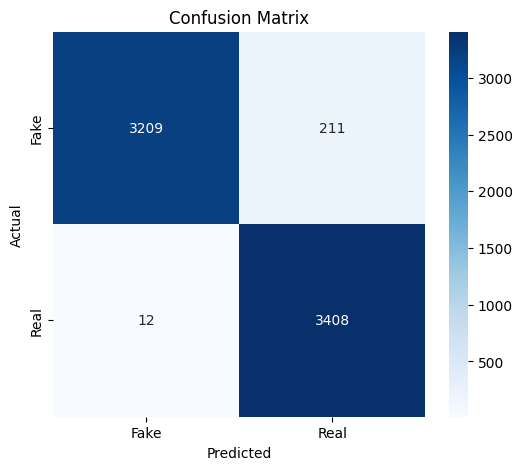

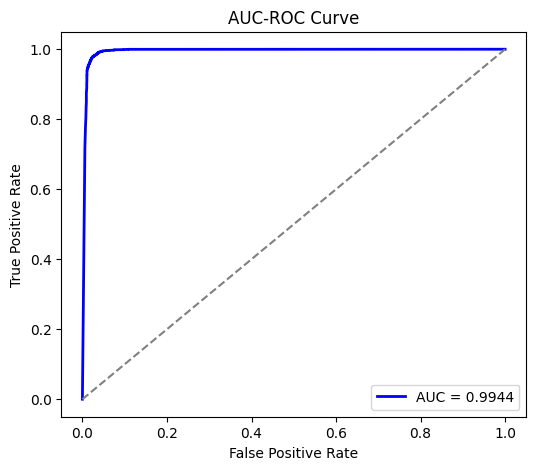

(0.9943951985226223, 0.9383040935672514)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
evaluate_model(model, test_loader, device)